In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin_cached_model as lcm
import pymc3 as pm
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 1000
    # variables        = 2
    chi-square         = 1.349
    reduced chi-square = 0.001
    Akaike info crit   = -6602.264
    Bayesian info crit = -6592.448
[[Variables]]
    amplitude:   0.84582718 +/- 0.006799 (0.80%) (init= 0.2054346)
    decay:       114.971279 +/- 1.312557 (1.14%) (init= 291.6468)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.704 



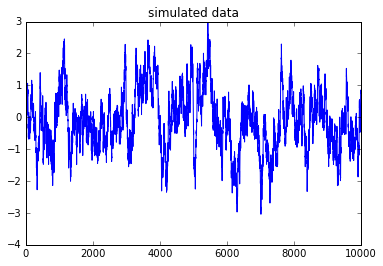

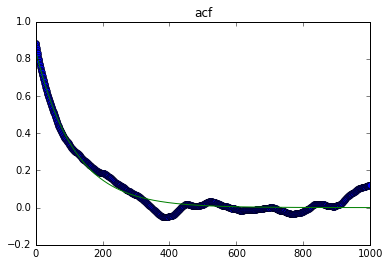

In [3]:
A,D = 1.0,1.0
delta_t=0.01
N=10000 # length of data set
P=1000 # range to fit acf

data = langevin.time_series(A=A,D=D,delta_t=delta_t,N=N)

plt.figure()
plt.plot(data)
plt.title('simulated data')

# calculate autocorrelation function
f = np.fft.rfft(data)
acf = np.fft.irfft(f * np.conjugate(f))
acf = np.fft.fftshift(acf) / N
autocorr=acf[int(N/2):]

y = autocorr[:min(int(N/2),P)]
t = np.arange(min(int(N/2),P))

mod=ExponentialModel()
pars = mod.guess(y, x=t)
out  = mod.fit(y, pars, x=t)
print(out.fit_report(min_correl=0.25))

plt.figure()
plt.plot(t,y,"o")
plt.plot(t,out.best_fit)
plt.title('acf')

In [4]:
# initial prior
# both D and A have mean 1 and std 10
alpha_A=0.01
beta_A=0.01
alpha_D=2.01
beta_D=1.01

In [5]:
# compile model for reuse
sm = lcm.LangevinIG()
sm.samples=100000

In [6]:
trace = sm.run(x=data,
                aD=alpha_D,
                bD=beta_D,
                aA=alpha_A,
                bA=beta_A,
                delta_t=0.01,
                N=10000)

Applied log-transform to D and added transformed D_log_ to model.
Applied log-transform to A and added transformed A_log_ to model.
 [-------100%-------] 100000 of 100000 in 154.3 sec. | SPS: 647.9 | ETA: 0.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12146ea20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1218aa8d0>]], dtype=object)

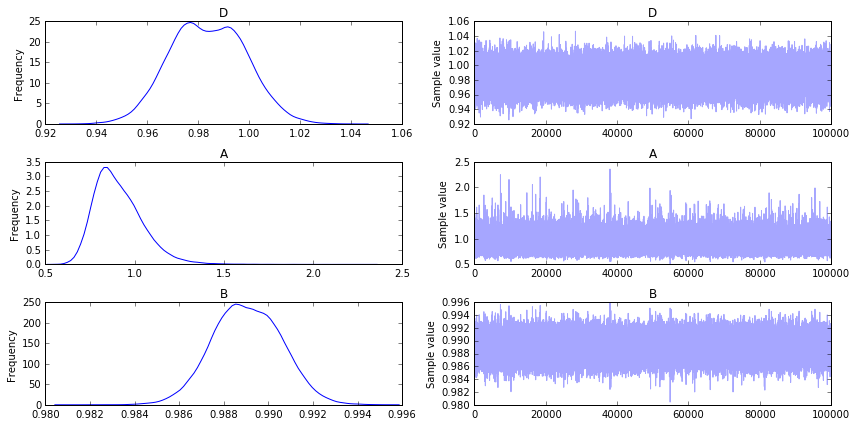

In [7]:
pm.traceplot(trace)

In [8]:
pm.summary(trace)


D:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.984            0.015            0.000            [0.956, 1.012]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.956          0.973          0.984          0.994          1.012


A:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.912            0.137            0.001            [0.678, 1.183]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.703          0.814          0.891          0.991          1.227


B:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------

In [11]:
print(np.percentile(trace['D'],(2.5,25,50,75,97.5)))
print(np.percentile(trace['D'],(5,95)))

[ 0.95620019  0.97319739  0.98364376  0.99445258  1.01215562]
[ 0.96023783  1.00785027]


In [ ]:
d95=np.std(trace['D'])*1.96